+ DictVectorizer 用法。

In [1]:
import pandas as pd

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [2]:
# info 查看缺失值的统计
selected_features = [
    'Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare'
]

In [3]:
X_train = train[selected_features]
X_test = test[selected_features]
y_train = train['Survived']

In [4]:
# Embarked 登船港口
X_train.head()

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
0,3,male,22.0,S,1,0,7.2500
1,1,female,38.0,C,1,0,71.2833
2,3,female,26.0,S,0,0,7.9250
3,1,female,35.0,S,1,0,53.1000
4,3,male,35.0,S,0,0,8.0500


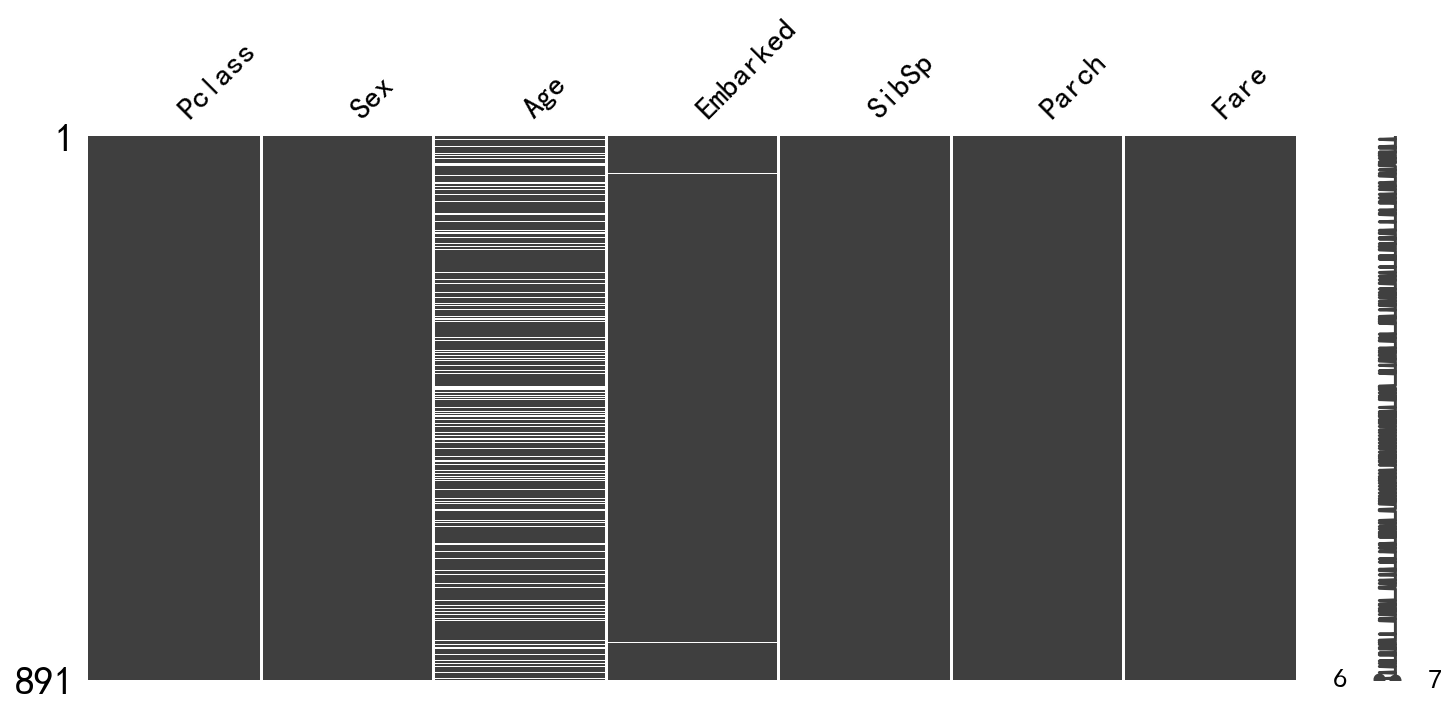

In [5]:
import missingno as msno

msno.matrix(X_train, figsize=(12, 5))
plt.show()

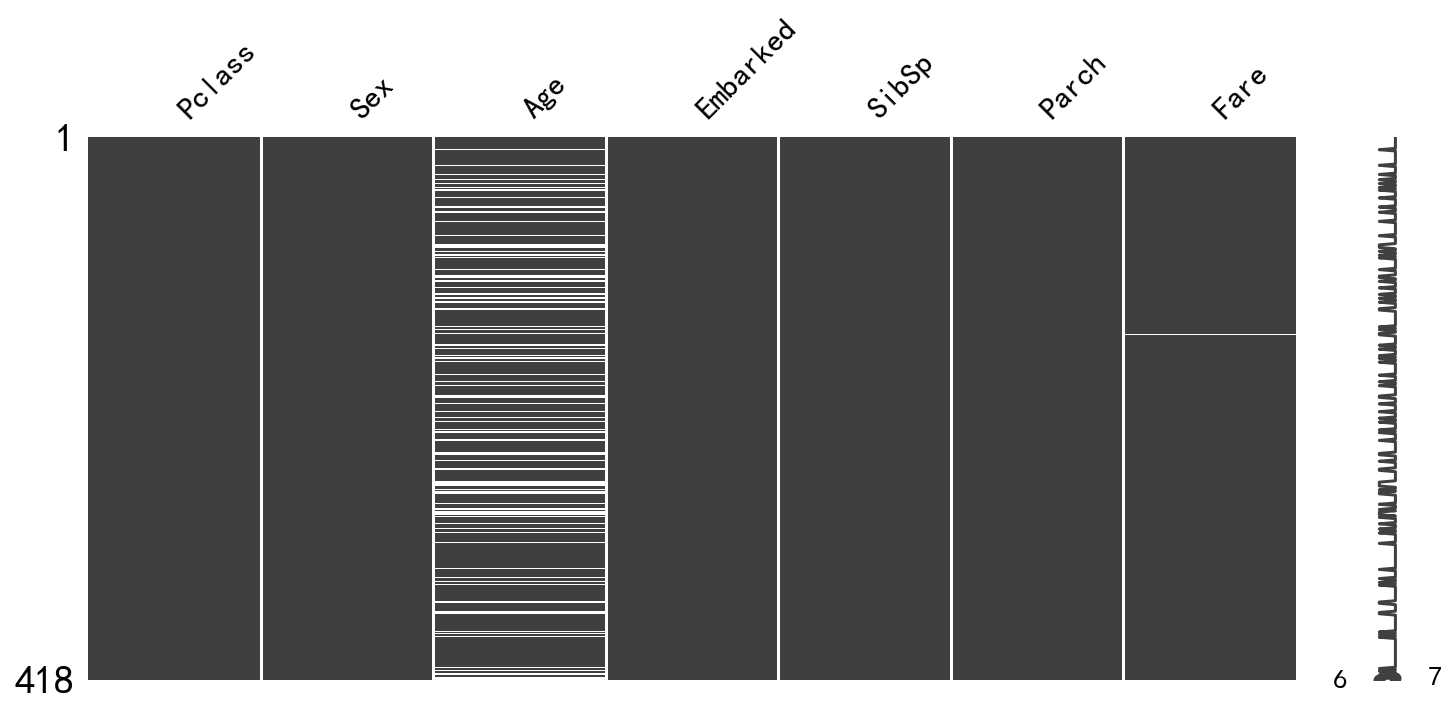

In [6]:
msno.matrix(X_test, figsize=(12, 5))
plt.show()

## 填充缺失值

+ Embarked：离散型，使用众数

In [7]:
# X_train['Embarked'].value_counts()
# X_test['Embarked'].value_counts()

# S 是众数，用它填充缺失值
X_train['Embarked'].fillna('S', inplace=True)
X_test['Embarked'].fillna('S', inplace=True)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


+ Age：连续型，使用平均数

In [8]:
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)
X_test['Age'].fillna(X_test['Age'].mean(), inplace=True)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


+ Fare：连续型，使用平均数

In [9]:
# Fare => 船票价格
# 训练数据集没有缺，测试数据集缺少 np.sum(X_test['Fare'].isnull())
X_test['Fare'].fillna(X_test['Fare'].mean(), inplace=True)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


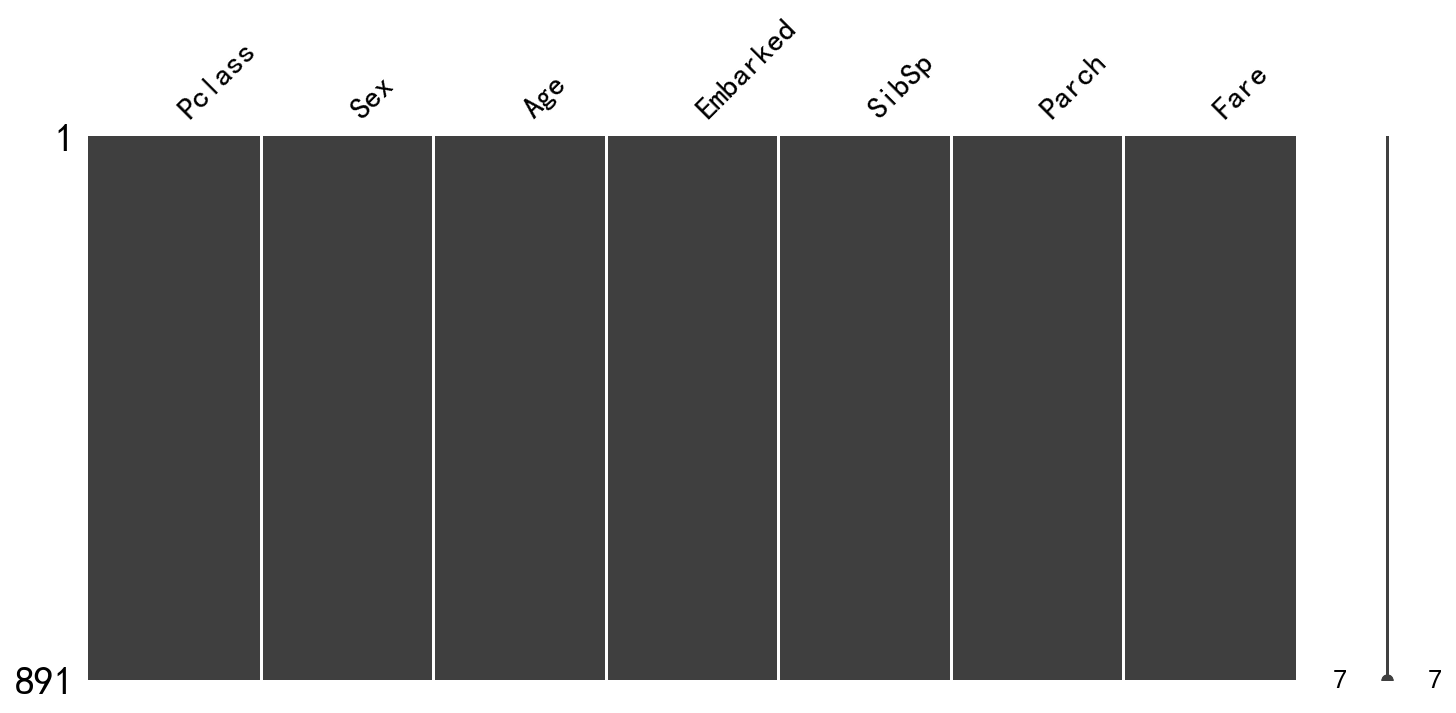

In [10]:
msno.matrix(X_train, figsize=(12, 5))
plt.show()

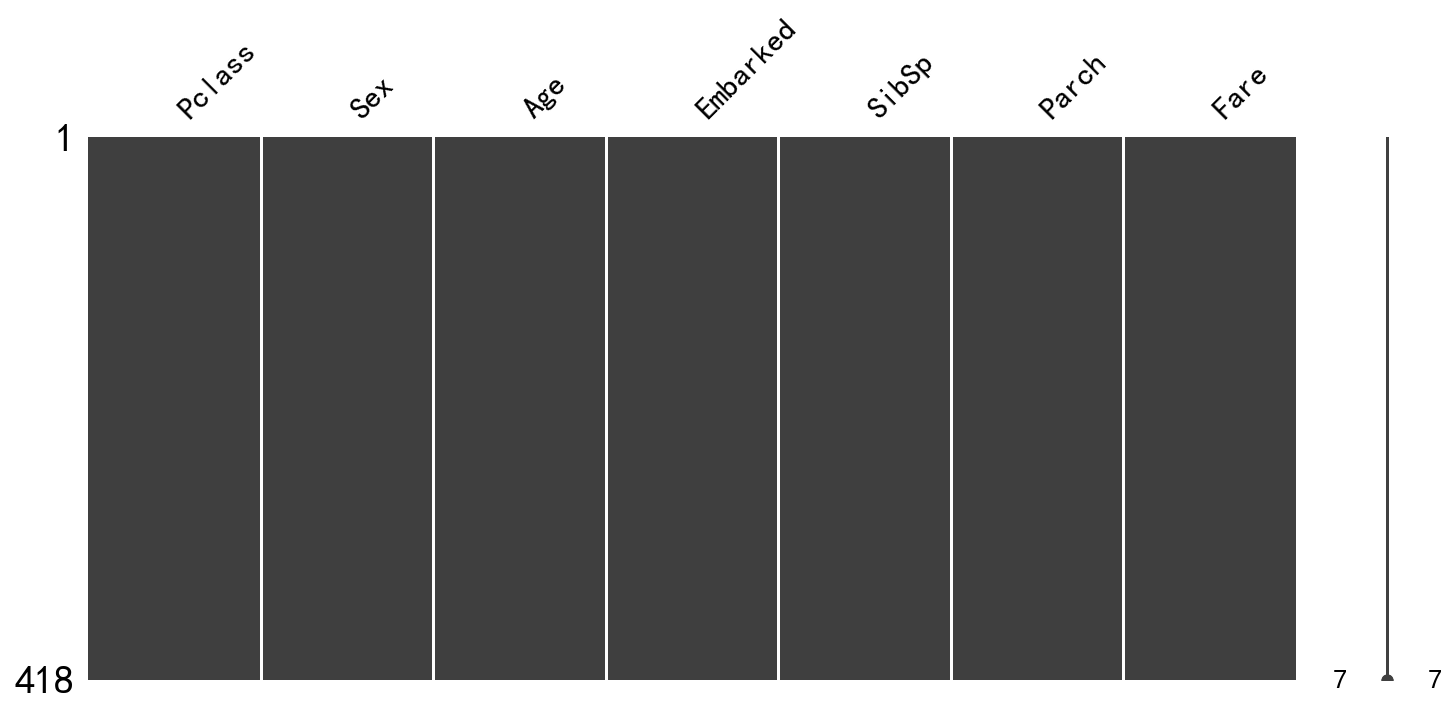

In [11]:
msno.matrix(X_test, figsize=(12, 5))
plt.show()

## 把离散型特征转换为独热编码

+ DictVectorizer

In [12]:
from sklearn.feature_extraction import DictVectorizer

dict_vec = DictVectorizer(sparse=False)
X_train_vec = dict_vec.fit_transform(X_train.to_dict(orient='record'))

In [13]:
dict_vec.feature_names_
# X_train_vec.tolist()

['Age',
 'Embarked=C',
 'Embarked=Q',
 'Embarked=S',
 'Fare',
 'Parch',
 'Pclass',
 'Sex=female',
 'Sex=male',
 'SibSp']

In [14]:
X_test_vec = dict_vec.transform(X_test.to_dict(orient='record'))
X_test_vec

array([[34.5       ,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [47.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [62.        ,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [38.5       ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [30.27259036,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [30.27259036,  1.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ]])

## 模型训练

使用交叉验证。

+ 交叉验证的时候，不能使用全部数据集训练，为了选择超参数，总要拿出一部分数据作为测试集。

### 随机森林

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=500)
rfc_scores = cross_val_score(rfc, X_train_vec, y_train, cv=5)
rfc_scores

array([0.77653631, 0.81005587, 0.84831461, 0.7752809 , 0.83050847])

In [16]:
rfc_scores.mean()

0.8081392317930396

### xgboost

In [17]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc_scores = cross_val_score(xgbc, X_train_vec, y_train, cv=5)
xgbc_scores

array([0.80446927, 0.81005587, 0.8258427 , 0.79775281, 0.85310734])

In [18]:
xgbc_scores.mean()

0.81824559798311

### 将随机森林算法训练的结果输出

In [19]:
rfc.fit(X_train_vec, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
rfc_y_predict = rfc.predict(X_test_vec)

rfc_submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': rfc_y_predict
})
rfc_submission.to_csv('../output/rfc_submission.csv', index=False)

### 将 xgbc 算法训练的结果输出

In [21]:
xgbc.fit(X_train_vec, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
xgbc_y_predict = xgbc.predict(X_test_vec)
xgbc_submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': xgbc_y_predict
})
xgbc_submission.to_csv('../output/xgbc_submission.csv', index=False)

## 使用网格搜索找到 xgbc 模型的最佳超参数

In [23]:
%%time
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': list(range(2, 7)),
    'n_estimators': list(range(100, 1100, 200)),
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 1.0]
}

xgbc_best = XGBClassifier()

gs = GridSearchCV(xgbc_best, params, n_jobs=-1, cv=5, verbose=1, refit=True)

gs.fit(X_train_vec, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.4s


CPU times: user 2.26 s, sys: 221 ms, total: 2.48 s
Wall time: 32.6 s


[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:   32.6s finished


In [24]:
print(gs.best_score_)

0.835016835016835


In [25]:
print(gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [26]:
xgbc_best_y_predict = gs.predict(X_test_vec)

In [27]:
xgbc_best_y_predict = gs.best_estimator_.predict(X_test_vec)

In [28]:
xgbc_best_submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': xgbc_best_y_predict
})

In [29]:
xgbc_best_submission.to_csv(
    '../output/xgbc_best_submission_1.csv', index=False)